In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
files = ['ETHUSDC-trades-2024-01.csv']
column_headings = ['trade ID', 'price', 'qty', 'base_qty', 'time', 'is_buyer_maker', '']

df_cex = pd.DataFrame()
dfs = []
for file in files:
    data = pd.read_csv(file, header = None, index_col = False)
    dfs.append(data)

df_cex = pd.concat(dfs, ignore_index=True)
df_cex.columns = column_headings

df_cex['time'] = pd.to_datetime(df_cex['time'], unit = 'ms')
df_cex.head()

,trade ID,price,qty,base_qty,time,is_buyer_maker,
0,33165689,2281.65,0.0888,202.610520,2024-01-01 00:00:03.953,False,True
1,33165690,2281.38,0.0060,13.688280,2024-01-01 00:00:12.961,True,True
2,33165691,2281.19,1.0789,2461.175891,2024-01-01 00:00:12.961,True,True
3,33165692,2281.19,0.1851,422.248269,2024-01-01 00:00:12.962,True,True
4,33165693,2281.19,0.5748,1311.228012,2024-01-01 00:00:12.962,True,True


In [3]:
df_cex.shape[0]

786022

In [4]:
dex_file_path = 'data_UV3_WETH_USDC_January2024.pkl'
df_dex = pd.read_pickle(dex_file_path)
df_dex.head()

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,blockNumber,symbol0,symbol1,price,tcost_usd,time
0,7695.197656,-3.368874,7687.888507,0xd36aac0c9676e984d72823fb662ce94d3ab5e551,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xea749fd6ba492dbc14c24fe8a3d08769229b896c,1.706746e+09,720697,2.004517e+10,2.004517e-08,19129888,USDC,WETH,2283.160587,32.983659,2024-01-31 23:59:59
1,164318.889753,-71.961440,164190.258312,0x1fd0c666094d8c5dae247aa6c3c4c33fd21bdc91,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,1.706746e+09,1673514,2.378692e+10,2.378692e-08,19129888,USDC,WETH,2283.160587,90.887475,2024-01-31 23:59:59
2,1000.000000,-0.437797,999.056241,0xe86866e5f456d5f986cec61e43bfcec6065b80eb,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,279656,2.268775e+10,2.268775e-08,19129888,USDC,WETH,2283.160587,14.486120,2024-01-31 23:59:59
3,15000.000000,-6.571360,14990.873565,0xcf99f91f0d834f26b8e7267ee99203bef3648edd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,280947,2.010458e+10,2.010458e-08,19129887,USDC,WETH,2281.563014,12.887003,2024-01-31 23:59:47
4,-2280.293805,1.000000,2280.074254,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,1.706746e+09,284804,3.171776e+10,3.171776e-08,19129885,USDC,WETH,2281.563014,20.610146,2024-01-31 23:59:23


In [5]:
df_cex.shape[0]

786022

Assumptions made:
1. Trade Size: Arbitrageurs execute larger trades compared to noise traders. We assume a certain threshold to classify a trade as "large" based on the dataset's distribution.
2. Trade Timing: Fast execution after price discrepancies are identified is key for arbitrage. We'll assume trades following significant price movements within a short timeframe indicate arbitrage.
3. Trading Frequency: High frequency of trades by a single sender within a short period may indicate an arbitrage strategy.
4. Market Conditions and Price Impact: Without explicit data on other market prices, we'll use large price movements in the DEX as a proxy for potential arbitrage opportunities.
5. Slippage and Transaction Costs: This model assumes that arbitrageurs are successful in managing slippage and costs effectively, but we lack the data to measure this directly.

In [6]:
unique_senders = df_dex['sender'].unique()
len(unique_senders)

283

In [7]:
def classify_traders_by_threshold(df_dex, threshold):
    """
    Classify traders based on a given threshold and return the counts of arbitrageurs and noise traders.
    """
    large_trade_threshold = df_dex['amountUSD'].quantile(threshold / 100.0)
    trader_classification = {}

    for sender in df_dex['sender'].unique():
        total_trade_amount_by_sender = df_dex[df_dex['sender'] == sender]['amountUSD'].sum()
        trader_classification[sender] = 'Arbitrageur' if total_trade_amount_by_sender >= large_trade_threshold else 'Noise Trader'
    
    # Count classifications
    classification_counts = {'Arbitrageur': 0, 'Noise Trader': 0}
    for classification in trader_classification.values():
        classification_counts[classification] += 1
    
    return classification_counts

In [8]:
thresholds = np.arange(50, 95, 5)

In [9]:
classification_counts_by_threshold = {t: {'Arbitrageur': 0, 'Noise Trader': 0} for t in thresholds}
for t in thresholds:
    classification_counts_by_threshold[t] = classify_traders_by_threshold(df_dex, t)

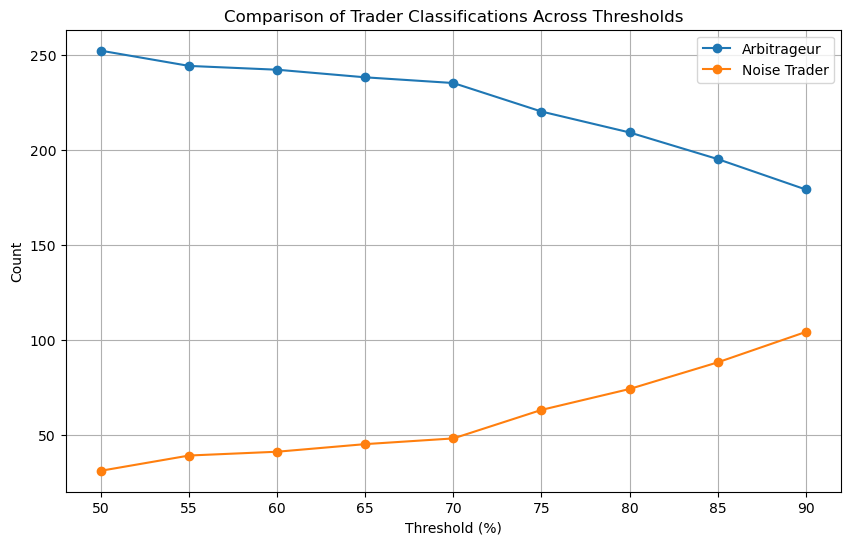

In [10]:
plt.figure(figsize=(10, 6))

arbitrageur_counts = [classification_counts_by_threshold[t]['Arbitrageur'] for t in thresholds]
noise_trader_counts = [classification_counts_by_threshold[t]['Noise Trader'] for t in thresholds]

# Creating a bar plot for arbitrageurs
plt.plot(thresholds, arbitrageur_counts, label='Arbitrageur', marker='o')

# Creating a bar plot for noise traders
plt.plot(thresholds, noise_trader_counts, label='Noise Trader', marker='o')

plt.title('Comparison of Trader Classifications Across Thresholds')
plt.xlabel('Threshold (%)')
plt.ylabel('Count')
plt.xticks(thresholds)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
def isArbitrageurV2(sender, df_dex, df_cex, price_difference_threshold):
    sender_trades = df_dex[df_dex['sender'] == sender]
    is_arbitrageur = False
    
    for index, trade in sender_trades.iterrows():
        # Ensure time columns are compatible for subtraction
        trade_time = pd.to_datetime(trade['timestamp'])  # Ensure column name matches your dataset
        df_cex['time'] = pd.to_datetime(df_cex['time'])  # Convert CEX 'time' column to datetime if not already
        
        # Find the closest CEX trade by timestamp
        closest_cex_trade = df_cex.iloc[(df_cex['time'] - trade_time).abs().argsort()[:1]]
        
        if not closest_cex_trade.empty:
            cex_price = closest_cex_trade['price'].iloc[0]
            price_difference = abs(trade['price'] - cex_price) / cex_price
            
            # Check for significant price difference
            if price_difference >= price_difference_threshold:
                # Check if there's a next trade in DEX data
                if index + 1 < len(sender_trades):
                    next_trade = sender_trades.iloc[index + 1]
                    next_trade_time = pd.to_datetime(next_trade['timestamp'])  # Ensure column name matches
                    if abs(next_trade['price'] - cex_price) < abs(trade['price'] - cex_price):
                        is_arbitrageur = True
                        break
    
    return is_arbitrageur

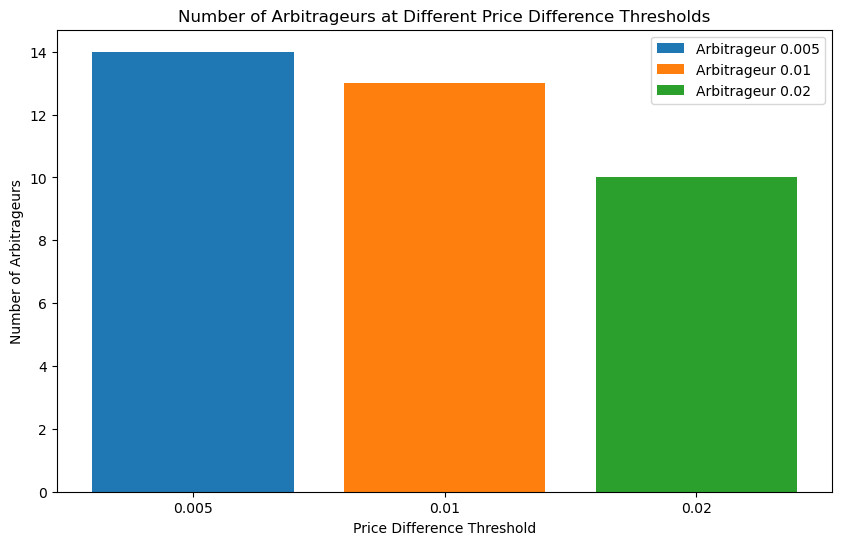

In [12]:
def classify_all_traders_v2(df_dex, df_cex, price_difference_threshold):
    unique_senders = df_dex['sender'].unique()
    classification_results = {'Arbitrageur': 0, 'Noise Trader': 0}
    
    for sender in unique_senders:
        if isArbitrageurV2(sender, df_dex, df_cex, price_difference_threshold):
            classification_results['Arbitrageur'] += 1
        else:
            classification_results['Noise Trader'] += 1
    
    return classification_results

# Varying price_difference_thresholds for comparison
thresholds = [0.005, 0.01, 0.02]  # Example thresholds
results = {}

for threshold in thresholds:
    results[threshold] = classify_all_traders_v2(df_dex, df_cex, threshold)

# Plotting the results
plt.figure(figsize=(10, 6))

for threshold, classification_counts in results.items():
    plt.bar(str(threshold), classification_counts['Arbitrageur'], label=f'Arbitrageur {threshold}')

plt.title('Number of Arbitrageurs at Different Price Difference Thresholds')
plt.xlabel('Price Difference Threshold')
plt.ylabel('Number of Arbitrageurs')
plt.legend()
plt.show()

In [13]:
x = '0xe37e799d5077682fa0a244d46e5649f71457bd09'
isArbitrageur(x, df_dex, df_cex)

NameError: name 'isArbitrageur' is not defined

In [ ]:
df_trader_classification = pd.DataFrame(list(trader_classification.items()), columns=['Sender', 'Classification'])
df_trader_classification.to_csv('trader_classification.csv', index=False)